In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)



In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy
from neuromancer.loggers import BasicLogger
import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank(seed=9)
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.
sys = gt_model


# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
integrator_node = Node(integrator, ['xn', 'u'], ['xn'], name='model')


In [4]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')

    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader

nsteps = 10  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

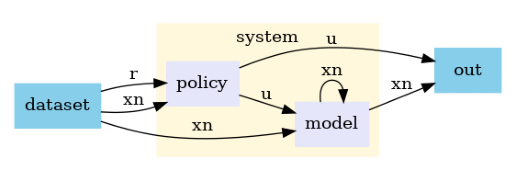

In [5]:
# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xn', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, integrator_node], nsteps=nsteps)
cl_system.show()


In [6]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]


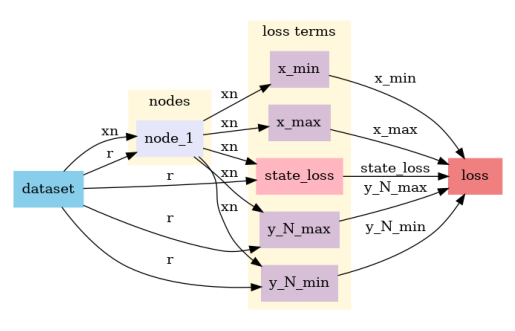

In [7]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [8]:
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.002)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
    patience=30,
    logger=logger
)

None
Number of parameters: 1282


In [10]:
# for _ in range(5):
#     print(f'************   training with {nsteps} steps   ************   ')
#     train_loader, dev_loader = get_policy_data(nsteps, n_samples)
#     trainer.train_data, trainer.dev_data = train_loader, dev_loader
#     trainer.problem = problem
#
#     # Train control policy
#     best_model = trainer.train()
#
#     # load best trained model
#     trainer.model.load_state_dict(best_model)
#
#     nsteps += 10
#     cl_system.nsteps = nsteps
#     trainer.badcount = 0


************   training with 10 steps   ************   
epoch: 0	train_loss: 3.74996	dev_loss: 3.89885	eltime:  4.14007
epoch: 1	train_loss: 3.57799	dev_loss: 3.73292	eltime:  4.46658
epoch: 2	train_loss: 3.29610	dev_loss: 3.43461	eltime:  4.82150
epoch: 3	train_loss: 2.85618	dev_loss: 2.96772	eltime:  5.16430
epoch: 4	train_loss: 2.52093	dev_loss: 2.63017	eltime:  5.48626
epoch: 5	train_loss: 2.36647	dev_loss: 2.49413	eltime:  5.82974
epoch: 6	train_loss: 2.25525	dev_loss: 2.39590	eltime:  6.15426
epoch: 7	train_loss: 2.17329	dev_loss: 2.32310	eltime:  6.51048
epoch: 8	train_loss: 2.11434	dev_loss: 2.26378	eltime:  6.83696
epoch: 9	train_loss: 2.07564	dev_loss: 2.22502	eltime:  7.16220
epoch: 10	train_loss: 2.05033	dev_loss: 2.20008	eltime:  7.51517
epoch: 11	train_loss: 2.03261	dev_loss: 2.18258	eltime:  7.90599
epoch: 12	train_loss: 2.01976	dev_loss: 2.16875	eltime:  8.29864
epoch: 13	train_loss: 2.01026	dev_loss: 2.15808	eltime:  8.62439
epoch: 14	train_loss: 2.00233	dev_loss: 2.15

In [24]:
policy.load_state_dict(torch.load("saved_models/pt_policy_Neural_WB_Model__20250312_154743.pth"))

<All keys matched successfully>

In [11]:
# from datetime import datetime
#
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
#
# # Generate timestamp
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#
# # Generate a valid filename with timestamp
# filename = "pt_policy_Neural_WB_Model_" + f"_{timestamp}.pth"
#
# # Define the full save path
# save_path = os.path.join(save_dir, filename)
#
# # Save the model state dictionary
# torch.save(policy.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_policy_Neural_WB_Model__20250312_154743.pth


In [12]:
import time
import pickle
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

def trajectory_dump(nsteps, step_length, cl_system, policy_name:str, dynamics_name:str):

    # generate reference
    np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=nsteps//step_length, rng=np.random.default_rng(seed=20))
    R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
    torch_ref = torch.cat([R, R], dim=-1)
    torch.manual_seed(0)
    # generate initial data for closed loop simulation
    data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
            'r': torch_ref}

    cl_system.nsteps = nsteps

    print(data['r'].shape)

    times = []
    trajectories = None

    for i in range(50):
        start = time.time()
        # perform closed-loop simulation
        trajectories = cl_system(data)
        end = time.time() - start
        times.append(end)

    traj = dict()
    traj['traj'] = trajectories
    traj['times'] = times
    filename = policy_name + "_" + dynamics_name + ".pkl"
    save_path = os.path.join(save_dir, filename)

    with open(save_path, "wb") as f:
        pickle.dump(traj, f)


In [14]:
trajectory_dump(nsteps=500, step_length=100, cl_system=cl_system, policy_name="policy_NN", dynamics_name="dynamics_WB")

torch.Size([1, 501, 2])


In [ ]:
# optimizer = torch.optim.AdamW(policy.parameters(), lr=0.002)
# #  Neuromancer trainer
# trainer = Trainer(
#     problem,
#     train_loader, dev_loader,
#     optimizer=optimizer,
#     epochs=200,
#     train_metric='train_loss',
#     eval_metric='dev_loss',
#     warmup=50,
#     patience=20
# )
# # Train control policy
# best_model = trainer.train()
# # load best trained model
# trainer.model.load_state_dict(best_model)
#


In [22]:
# # Define directory and filename to save the pretrained model
# save_dir = "saved_models"
# os.makedirs(save_dir, exist_ok=True)
# save_path = os.path.join(save_dir, "pt_policy.pth")
#
# # Save the model state dictionary
# torch.save(policy.state_dict(), save_path)
# print(f"Model saved at {save_path}")


Model saved at saved_models/pt_policy.pth


In [25]:
import copy
pt_policy = copy.deepcopy(policy)

In [26]:
nsteps = 750
step_length = 150
torch.manual_seed(0)
seed = 20
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

### Rollout over the ground truth system (used for training)

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

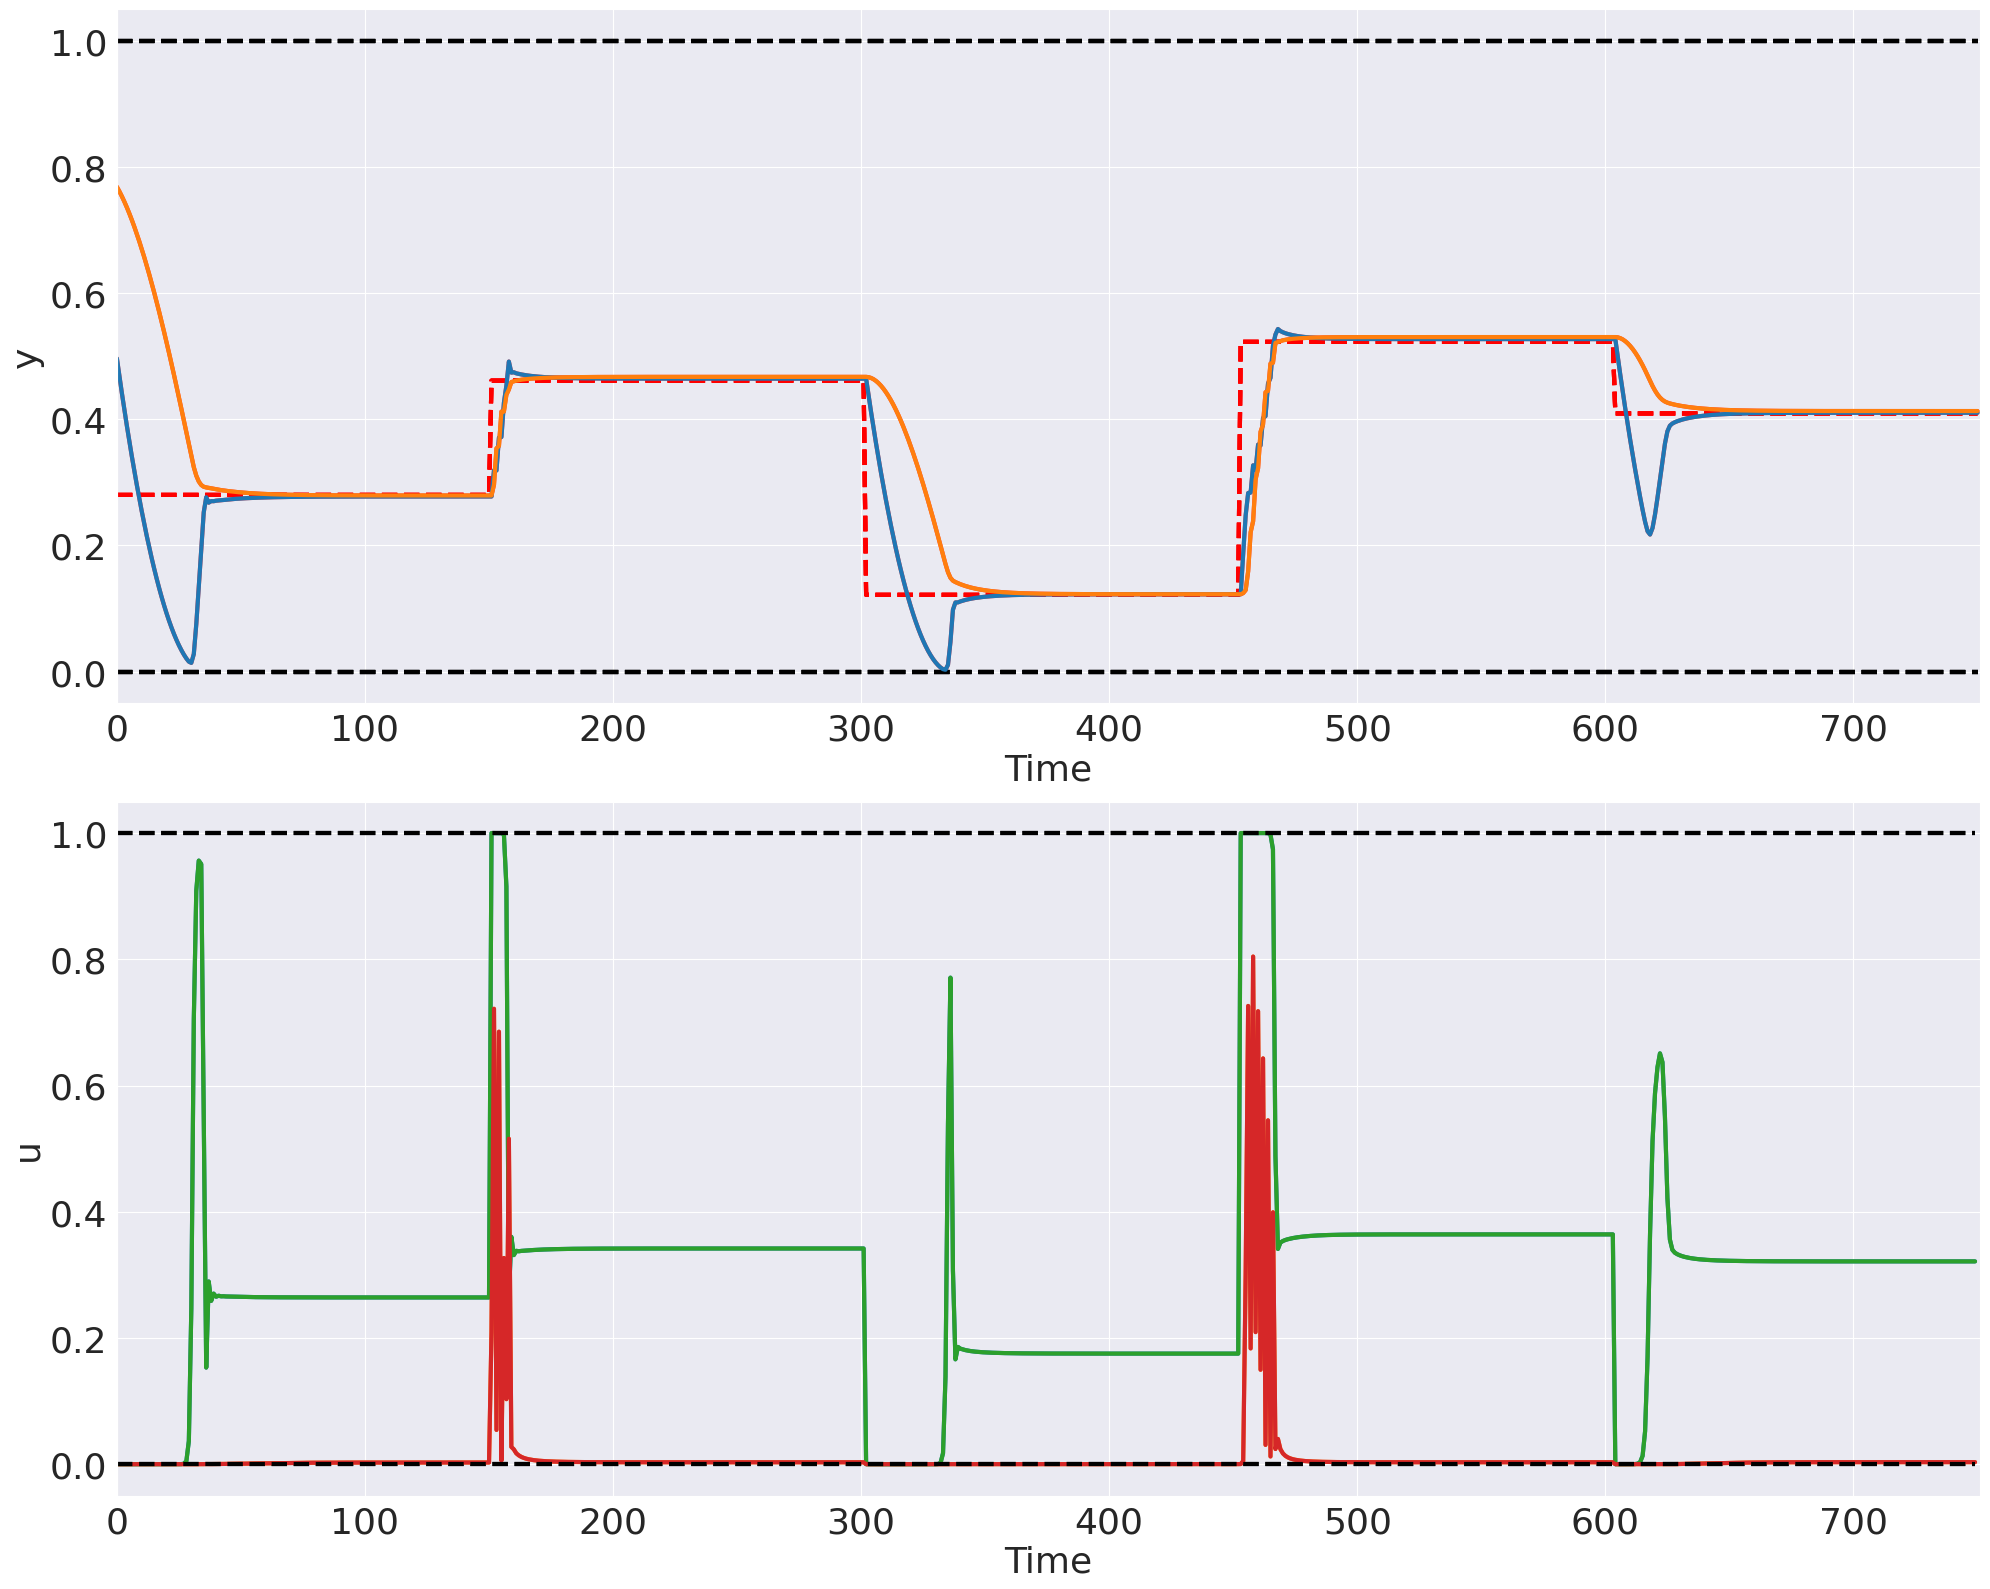

In [27]:
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1, requires_grad=False))
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2, requires_grad=False))

cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

### Changing the ODE parameters (Adding Noise)

In [37]:
torch.manual_seed(0)
noise_level = 0.2
noise = torch.randn(1) * noise_level
c1 = nn.Parameter(torch.tensor(gt_model.c1) + noise, requires_grad=False)
c2 = nn.Parameter(torch.tensor(gt_model.c2) + noise, requires_grad=False)
print("New c1: ",c1)
print("New c2: ",c2)

New c1:  Parameter containing:
tensor([0.3882])
New c2:  Parameter containing:
tensor([0.3482])


In [28]:
# noise_level = 0.4
# noise = torch.randn(1) * noise_level
# two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1) + noise, requires_grad=False)
# two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2) + noise, requires_grad=False)

two_tank.c1 = nn.Parameter(torch.tensor(0.15), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(0.03), requires_grad=False)
print("New c1: ",two_tank.c1)
print("New c2: ",two_tank.c2)

New c1:  Parameter containing:
tensor(0.1500)
New c2:  Parameter containing:
tensor(0.0300)


### Rolling over new system

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

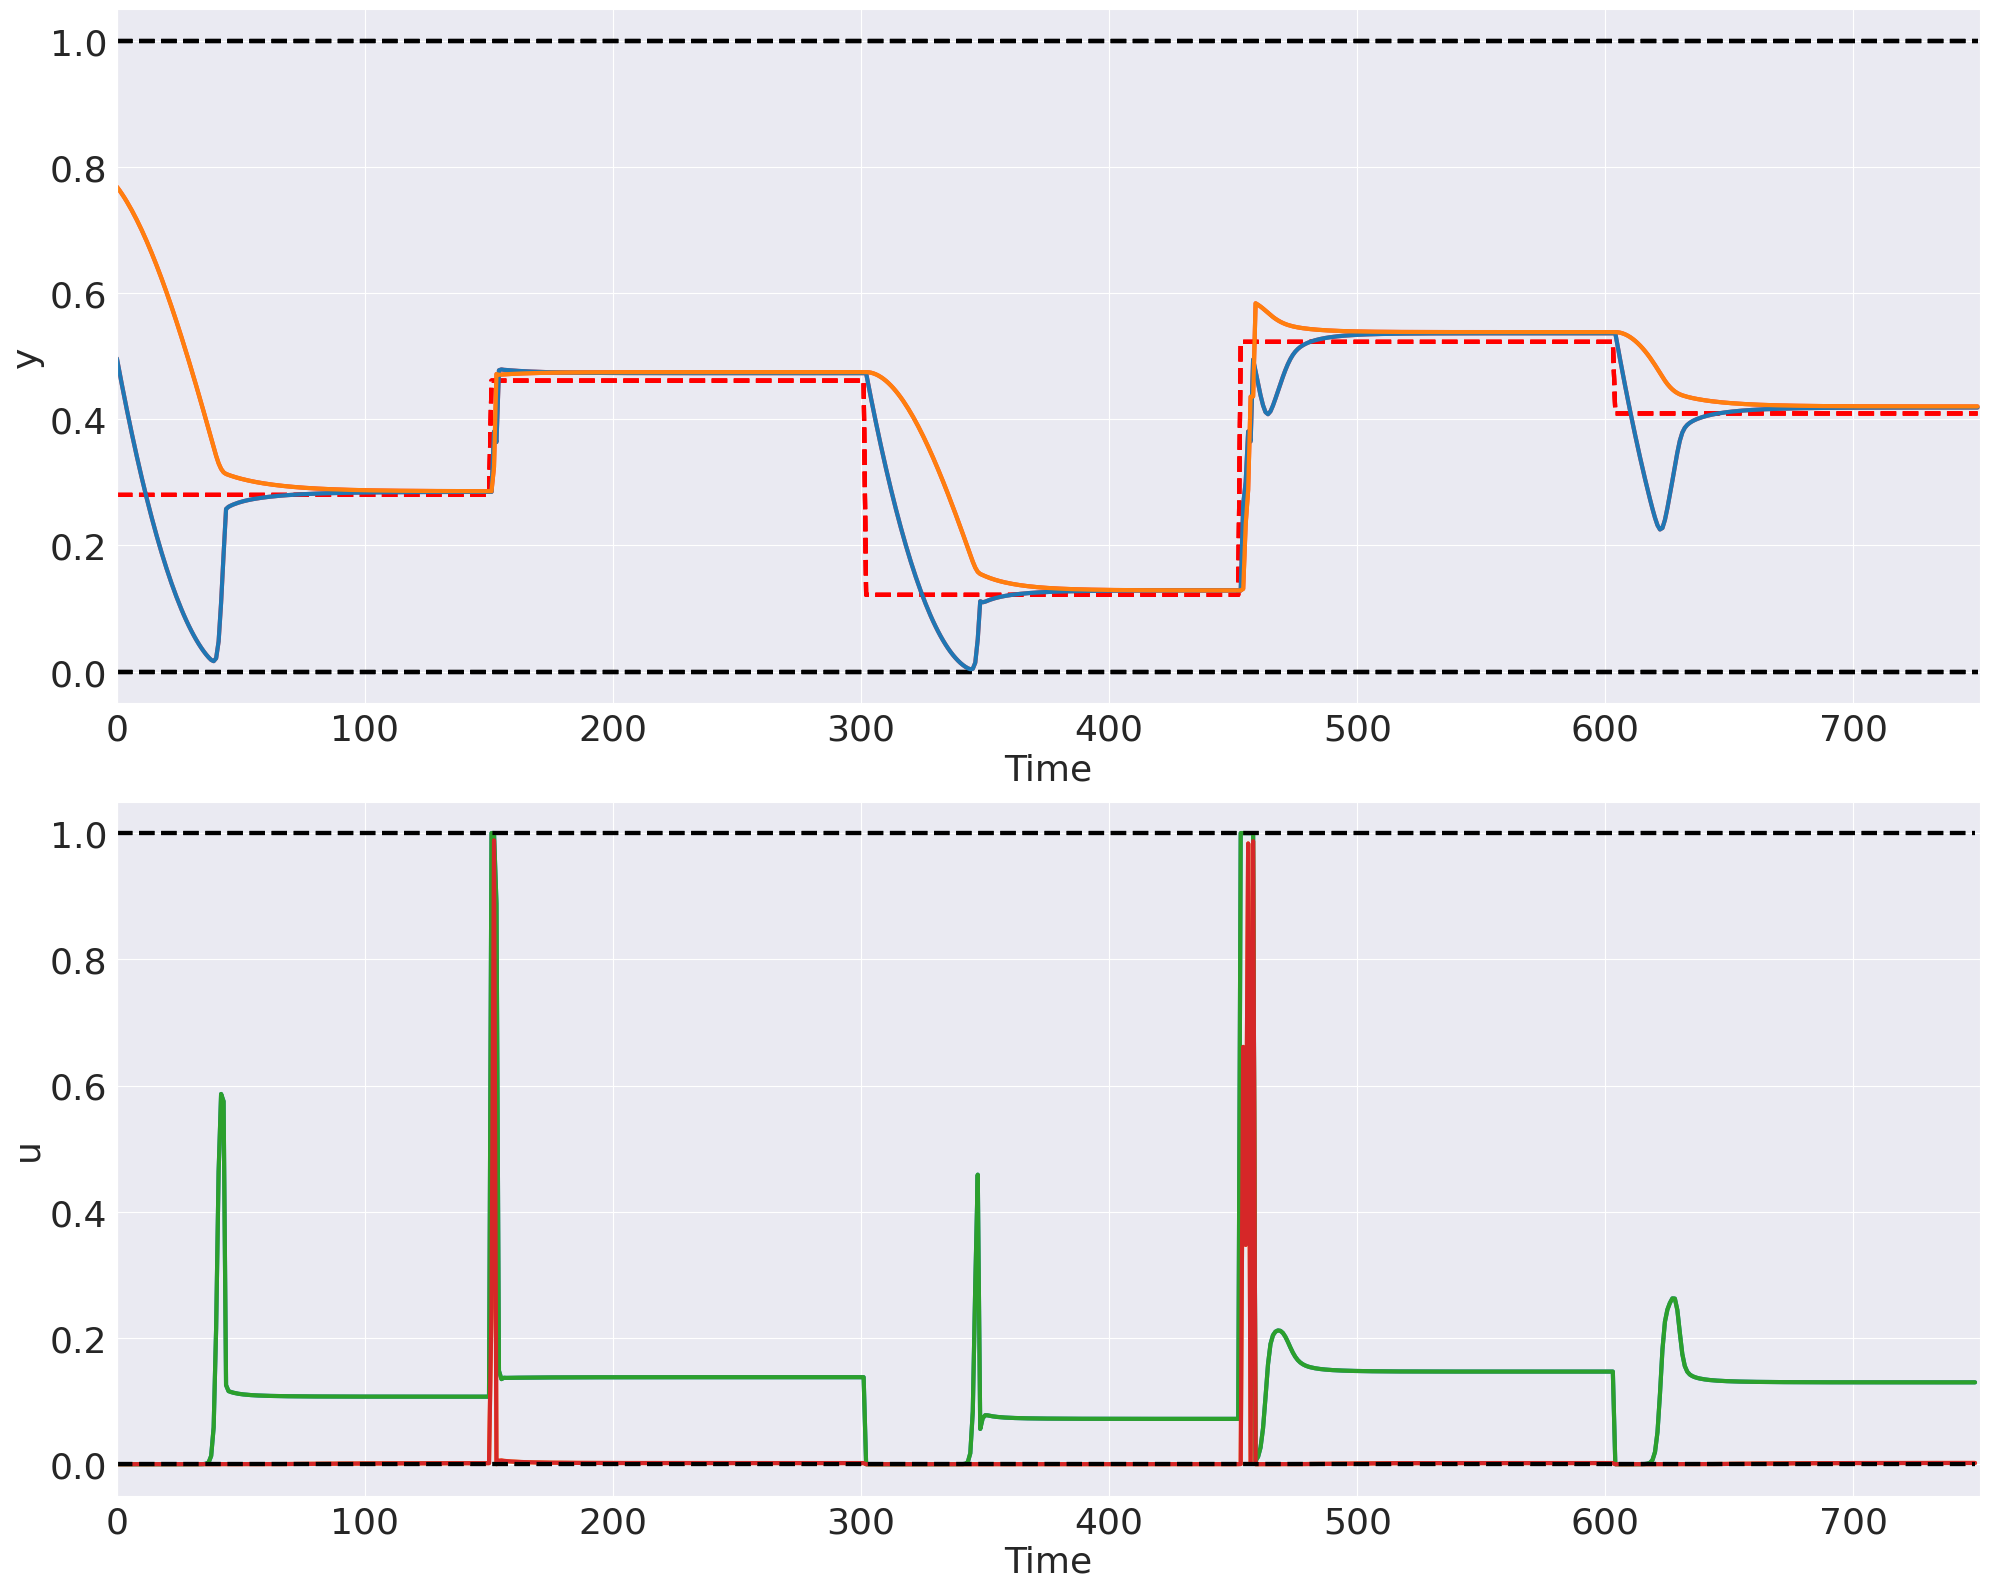

In [29]:
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

### Online Adaptation

we start rolling out with the initial value, and then after taking each step, we train the model with the data we have.
For example, we start at t=0, we go to the next step, we train the model with the loss w.r.t the policy parameters. (we gradually increase the horizon upto horizon=50). This continues untill the end the of the test data


In [30]:
nsteps = 500
step_length = 100

# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=nsteps//step_length, rng=np.random.default_rng(seed=20))
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
torch.manual_seed(0)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

In [31]:
#defining criterion and optimizer
import copy
horizon = 10
criterion = torch.nn.MSELoss()
steps_trajectories = {}


In [32]:
for steps in [5,10,30,50]:
    new_cl_system = copy.deepcopy(cl_system)
    new_policy = new_cl_system.nodes[0]
    x_trajectory = data['xn'].detach()[:, 0, :].unsqueeze(1)
    optimizer = torch.optim.AdamW(new_policy.parameters(), lr=0.001)
    #Online adaptation loop:
    for i in range (1,len(data['r'][0])):
        print('------', "Steping time step: ",i, '-------')
        #We rollout the closed loop system with the initial value:
        new_cl_system.nsteps = i
        trajectories = new_cl_system(data)

        #gradually increasing the horizon:
        l_horizon = min(i,horizon)

        #Getting the last l_horizon data from test data and calculate the loss
        T_xn = len(trajectories['xn'][0])
        loss = 5. * criterion(trajectories['xn'][:,-l_horizon:, :], trajectories['r'][:, T_xn - l_horizon : T_xn, :]) + criterion(trajectories['xn'], trajectories['r'][:, :T_xn])

        #backprop through policy network
        optimizer.zero_grad()
        loss.backward()

        #taking gradient update steps
        for _ in range(steps):
            optimizer.step()
        print('-------', f"Loss in {i}th steps: ",loss.item(), '-------')

        #setting the initial value to the latest timestep (this is for knowing how the controller is performing online):
        new_cl_system.nsteps = 1
        next_step_data = new_cl_system({'xn': x_trajectory[:,-1,:].unsqueeze(0), 'r': data['r'][:, len(x_trajectory[0]), :].unsqueeze(0)})
        x_trajectory = torch.cat([x_trajectory, next_step_data['xn'].detach()[:,-1:,:]], dim=1)

    steps_trajectories[steps] = {}
    steps_trajectories[steps]["xn"] = x_trajectory
    steps_trajectories[steps]["u"] = trajectories['u'].detach()





------ Steping time step:  1 -------
------- Loss in 1th steps:  0.8171432018280029 -------
------ Steping time step:  2 -------
------- Loss in 2th steps:  0.7975223660469055 -------
------ Steping time step:  3 -------
------- Loss in 3th steps:  0.7786154747009277 -------
------ Steping time step:  4 -------
------- Loss in 4th steps:  0.7603957653045654 -------
------ Steping time step:  5 -------
------- Loss in 5th steps:  0.7428379058837891 -------
------ Steping time step:  6 -------
------- Loss in 6th steps:  0.7259167432785034 -------
------ Steping time step:  7 -------
------- Loss in 7th steps:  0.7096086740493774 -------
------ Steping time step:  8 -------
------- Loss in 8th steps:  0.6938908100128174 -------
------ Steping time step:  9 -------
------- Loss in 9th steps:  0.678740918636322 -------
------ Steping time step:  10 -------
------- Loss in 10th steps:  0.6641378402709961 -------
------ Steping time step:  11 -------
------- Loss in 11th steps:  0.6361842155

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

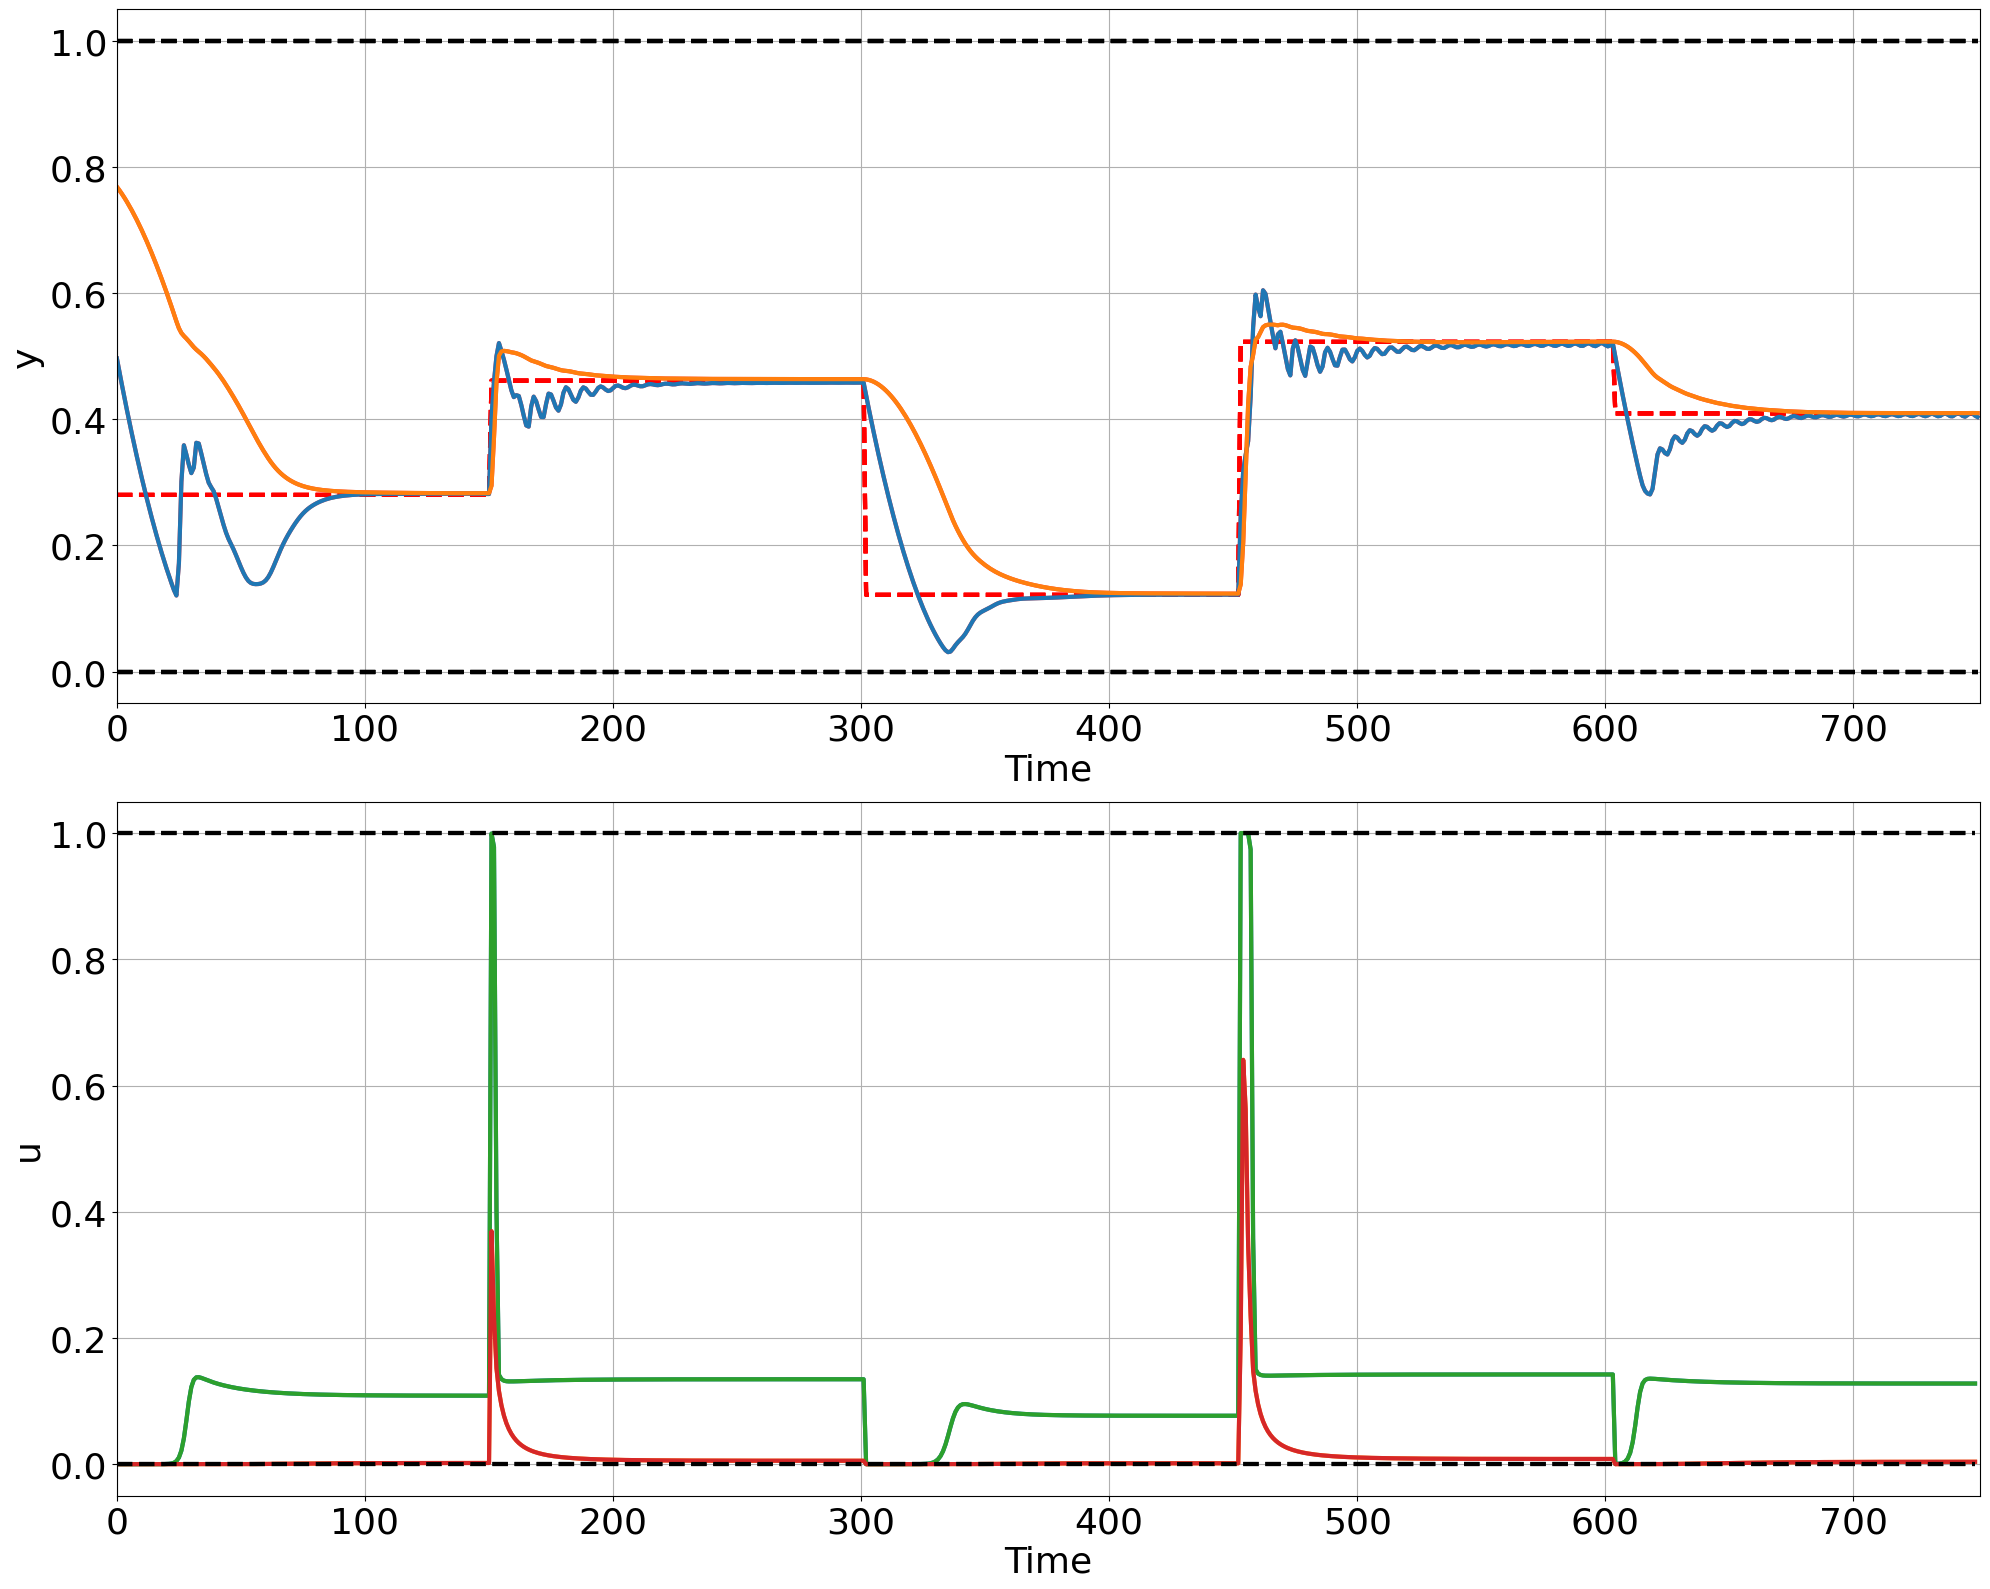

In [50]:
pltCL(Y=x_trajectory.detach().squeeze(0),
      R=data['r'][:,:len(x_trajectory.detach().squeeze(0)),:].squeeze(0),
      U=trajectories['u'].detach()[:,:len(x_trajectory.detach().squeeze(0)),:].squeeze(0),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

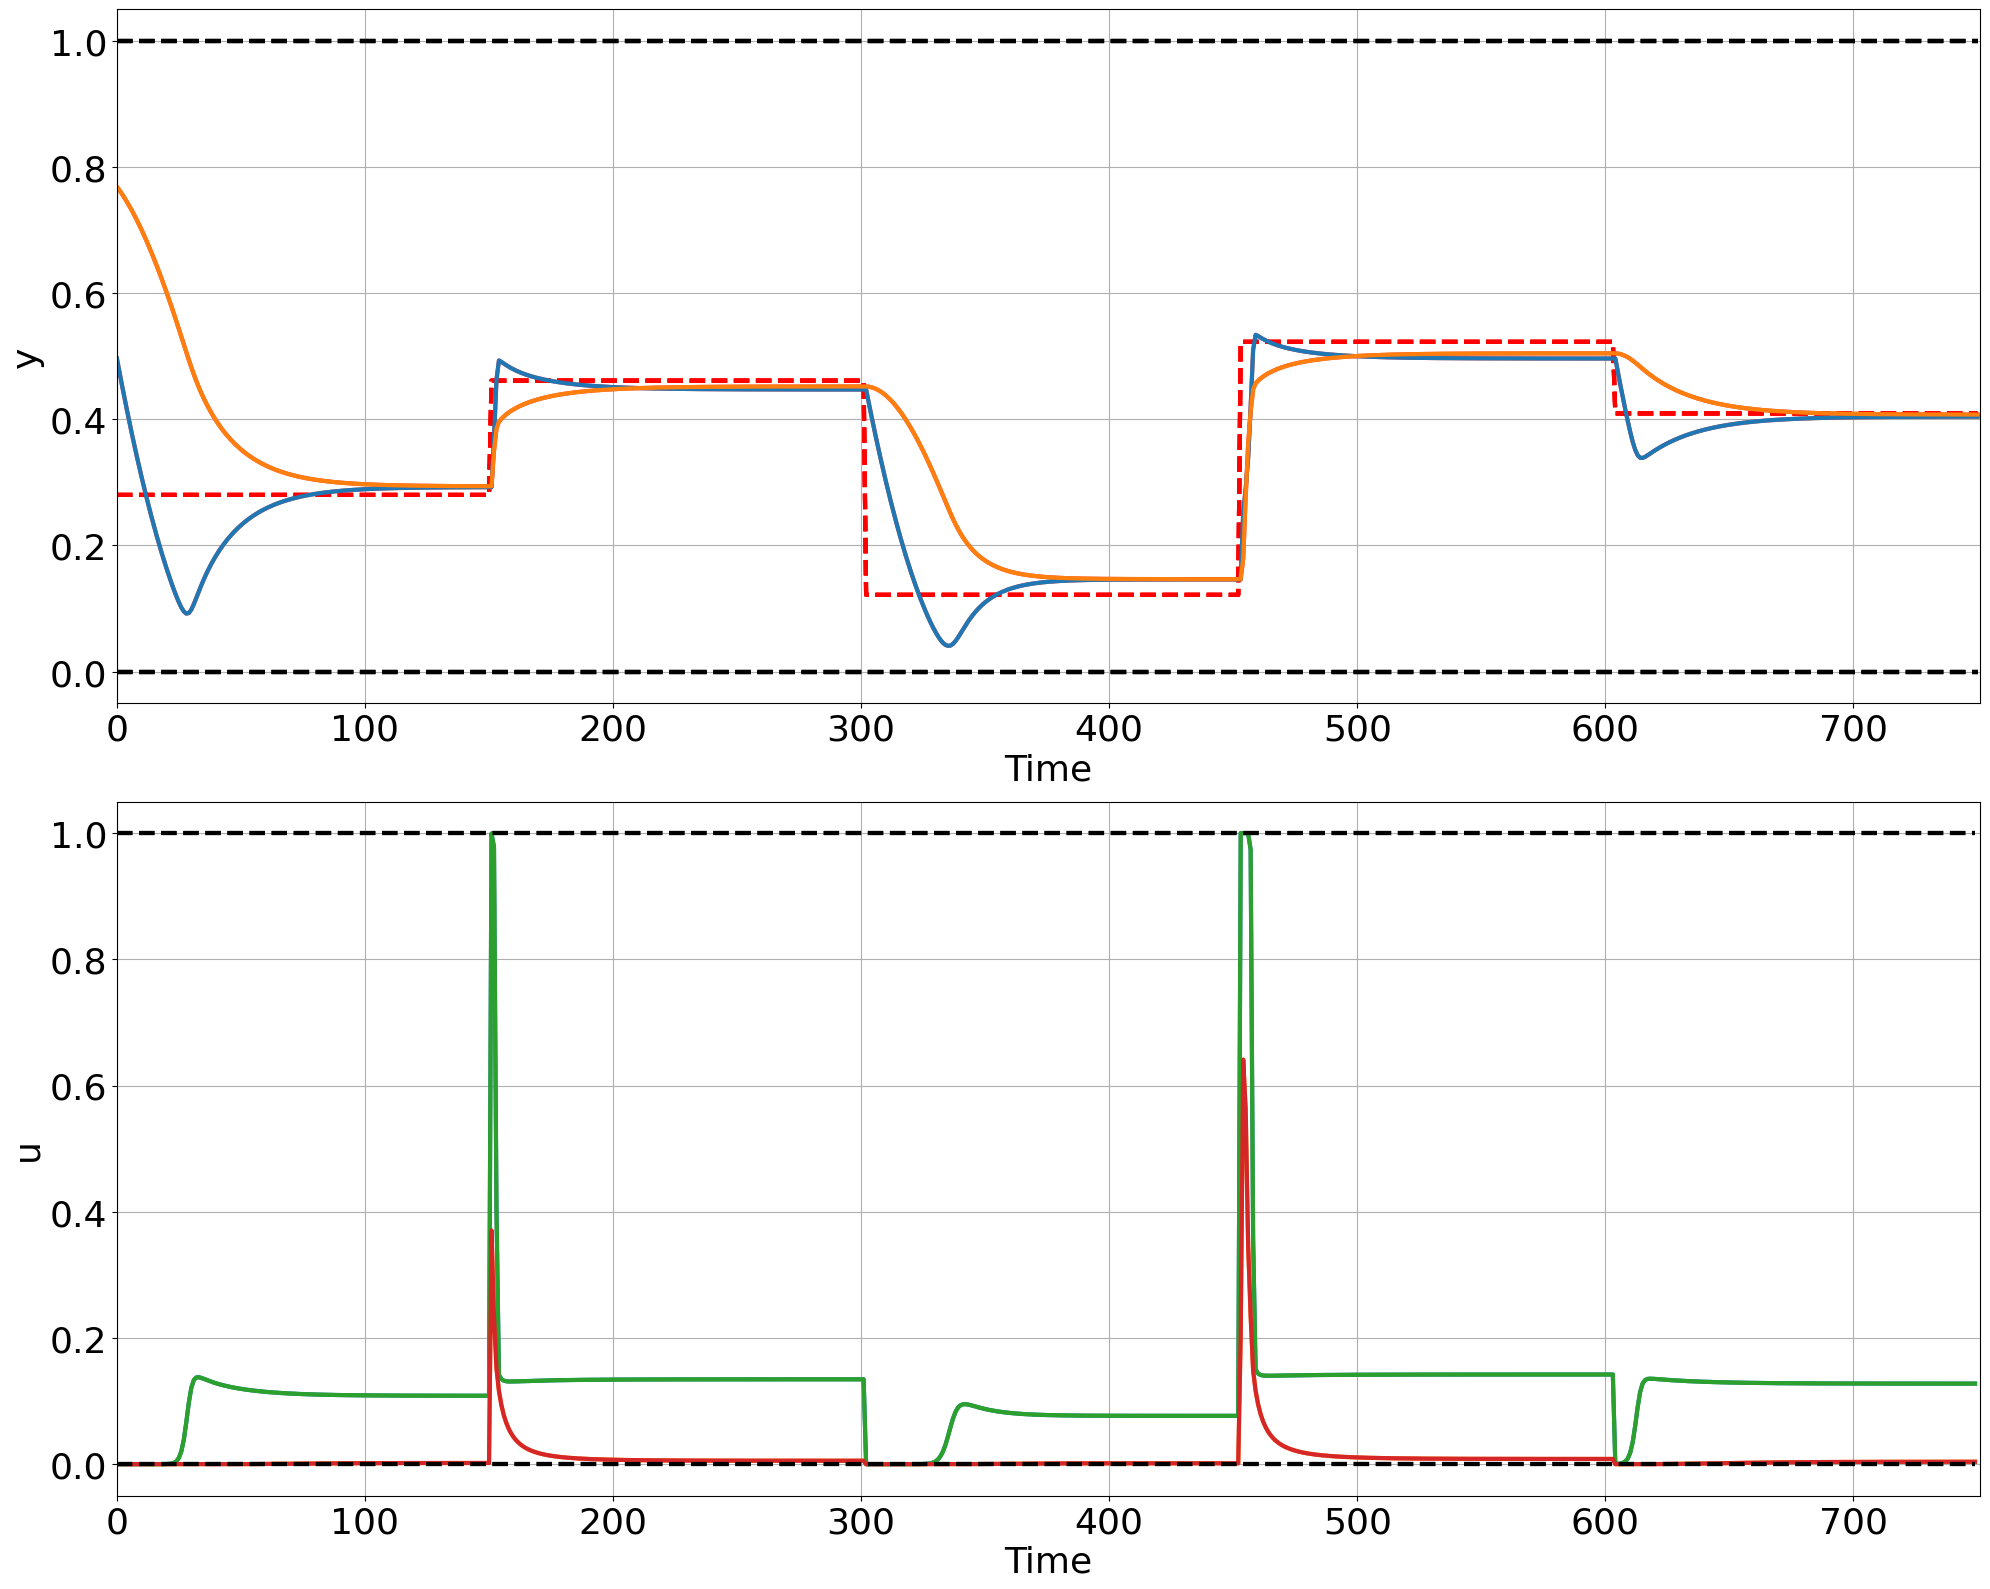

In [53]:
two_tank.c1 = nn.Parameter(torch.tensor(0.15), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(0.03), requires_grad=False)

cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)